In [1]:
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, accuracy_score, precision_recall_curve, precision_score, recall_score
import matplotlib.pyplot as plt
import pickle as pkl
import numpy as np
import math

In [2]:
def sig(x):
  return 1 / (1 + math.exp(-x))

In [3]:
with open("/Users/aviadsusman/Documents/Python_Projects/FeatureLevelAttention/FLA/results/diabetes/test_labels.pkl", "rb") as file:
    test_labels = pkl.load(file=file)
with open("/Users/aviadsusman/Documents/Python_Projects/FeatureLevelAttention/FLA/results/diabetes/test_losses_dict.pkl", "rb") as file:
    test_losses_dict = pkl.load(file=file)
with open("/Users/aviadsusman/Documents/Python_Projects/FeatureLevelAttention/FLA/results/diabetes/test_pred_dict.pkl", "rb") as file:
    test_pred_dict = pkl.load(file=file)
with open("/Users/aviadsusman/Documents/Python_Projects/FeatureLevelAttention/FLA/results/diabetes/test_losses_dict_1_to_4.pkl", "rb") as file:
    test_losses_dict_1_to_4 = pkl.load(file=file)
with open("/Users/aviadsusman/Documents/Python_Projects/FeatureLevelAttention/FLA/results/diabetes/test_pred_dict_1_to_4.pkl", "rb") as file:
    test_pred_dict_1_to_4 = pkl.load(file=file)
    
with open("/Users/aviadsusman/Documents/Python_Projects/FeatureLevelAttention/FLA/results/res/diabetes/test_losses_dict.pkl", "rb") as file:
    test_losses_dict_res = pkl.load(file=file)
with open("/Users/aviadsusman/Documents/Python_Projects/FeatureLevelAttention/FLA/results/res/diabetes/test_pred_dict.pkl", "rb") as file:
    test_pred_dict_res = pkl.load(file=file)
with open("/Users/aviadsusman/Documents/Python_Projects/FeatureLevelAttention/FLA/results/res/diabetes/test_losses_dict_1_to_4.pkl", "rb") as file:
    test_losses_dict_res_1_to_4 = pkl.load(file=file)
with open("/Users/aviadsusman/Documents/Python_Projects/FeatureLevelAttention/FLA/results/res/diabetes/test_pred_dict_1_to_4.pkl", "rb") as file:
    test_pred_dict_res_1_to_4 = pkl.load(file=file)

In [4]:
test_losses_dict_res = {**test_losses_dict_res_1_to_4, **test_losses_dict_res}
test_losses_dict = {**test_losses_dict_1_to_4, **test_losses_dict}
test_pred_dict_res = {**test_pred_dict_res_1_to_4, **test_pred_dict_res}
test_pred_dict = {**test_pred_dict_1_to_4, **test_pred_dict}

In [5]:
test_losses_dict_res = {f'{k} res': v for k,v in test_losses_dict_res.items()}
test_pred_dict_res = {f'{k} res': v for k,v in test_pred_dict_res.items()}

In [6]:
test_losses_dict = {**test_losses_dict, **test_losses_dict_res}
test_pred_dict = {**test_pred_dict, **test_pred_dict_res}

In [7]:
test_losses_dict.keys()
del test_losses_dict[10]
del test_losses_dict[15]
del test_losses_dict['10 res']
del test_losses_dict['15 res']
del test_pred_dict[10]
del test_pred_dict[15]
del test_pred_dict['10 res']
del test_pred_dict['15 res']

In [8]:
test_pred_dict_sigmoid = {k: [] for k in test_pred_dict.keys()}
for k,v in test_pred_dict.items():
    for seed in range(len(v)):
        test_pred_dict_sigmoid[k].append([sig(x[0]) for x in test_pred_dict[k][seed]])

In [9]:
test_labels_lists = [[x[0].astype(int) for x in test_labels[i]] for i in range(len(test_labels))]

In [12]:
test_pred_dict_sigmoid = {0: test_pred_dict_sigmoid.pop(0), **test_pred_dict_sigmoid}

In [13]:
test_pred_dict_sigmoid.keys()

dict_keys([0, 1, 2, 3, 4, 5, '1 res', '2 res', '3 res', '4 res', '5 res'])

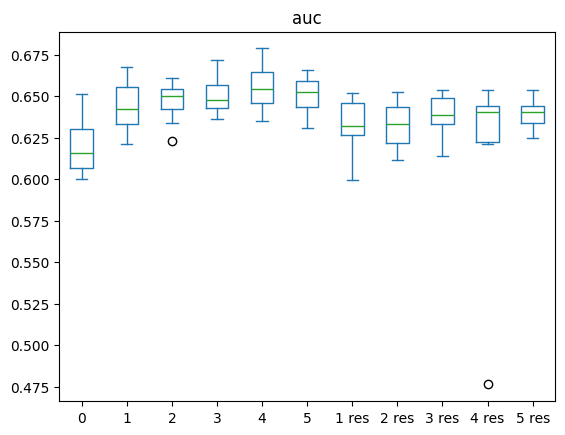

In [15]:
aucs = {k:[] for k in test_pred_dict_sigmoid.keys()}
for k in aucs.keys():
    for seed in range(len(test_labels_lists)):
        aucs[k].append(roc_auc_score(test_labels_lists[seed], test_pred_dict_sigmoid[k][seed]))
aucs_df = pd.DataFrame(aucs)
aucs_df
aucs_df.plot.box()
plt.title('auc')
plt.show()

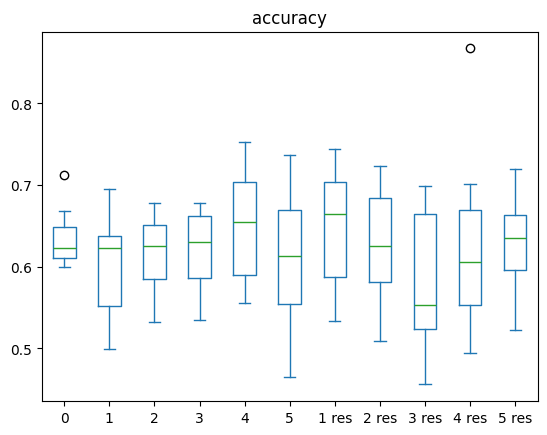

In [16]:
accs = {k:[] for k in test_pred_dict_sigmoid.keys()}
for k in aucs.keys():
    for seed in range(len(test_labels_lists)):
        decisions =  [y>0.5 for y in test_pred_dict_sigmoid[k][seed]]
        accs[k].append(accuracy_score(test_labels_lists[seed], decisions))
accs_df = pd.DataFrame(accs)
accs_df
accs_df.plot.box()
plt.title('accuracy')
plt.show()

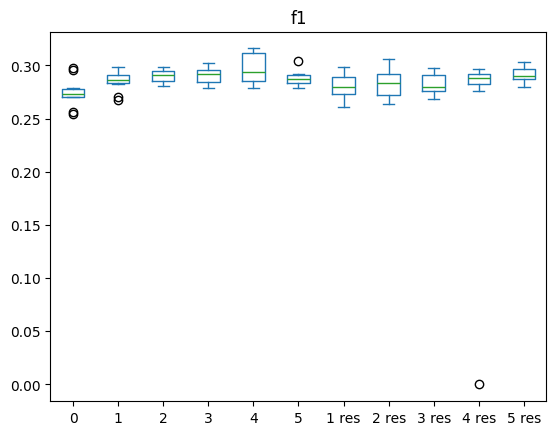

In [17]:
f1s = {k:[] for k in test_pred_dict_sigmoid.keys()}
for k in aucs.keys():
    for seed in range(len(test_labels_lists)):
        decisions =  [y>0.5 for y in test_pred_dict_sigmoid[k][seed]]
        f1s[k].append(f1_score(test_labels_lists[seed], decisions, pos_label=1))
f1s_df = pd.DataFrame(f1s)
f1s_df
f1s_df.plot.box()
plt.title('f1')
plt.show()

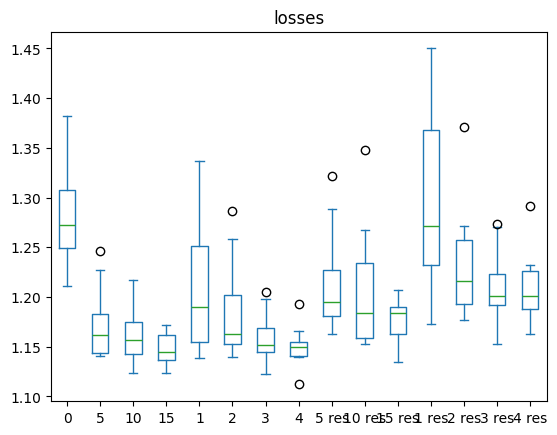

In [103]:
# if len(test_losses_dict[20]) != 10:
#     test_losses_dict[20].extend(test_losses_dict[20])
#     test_losses_dict[25].extend(test_losses_dict[25])
losses_df = pd.DataFrame(test_losses_dict)
losses_df.plot.box()
plt.title('losses')
plt.show()

In [18]:
def fmax_score(y_test, y_score, beta=1.0, pos_label=1):
    fmax_score, _, _, threshold_fmax = fmax_precision_recall_threshold(
        y_test, y_score, beta=beta, pos_label=pos_label
    )
    return fmax_score, threshold_fmax


def fmax_precision_recall_threshold(labels, y_score, beta=1.0, pos_label=1):
    """
    Radivojac, P. et al. (2013). A Large-Scale Evaluation of Computational Protein
    Function Prediction. Nature Methods, 10(3), 221-227.
    Manning, C. D. et al. (2008). Evaluation in Information Retrieval. In
    Introduction to Information Retrieval. Cambridge University Press.
    """
    if pos_label == 0:
        labels = 1 - np.array(labels)
        y_score = 1 - np.array(y_score)

    precision_scores, recall_scores, thresholds = precision_recall_curve(
        labels, y_score
    )

    np.seterr(divide="ignore", invalid="ignore")
    f_scores = (
        (1 + beta**2)
        * (precision_scores * recall_scores)
        / ((beta**2 * precision_scores) + recall_scores)
    )

    arg_fmax = np.nanargmax(f_scores)

    fmax_score = f_scores[arg_fmax]
    precision_fmax = precision_scores[arg_fmax]
    recall_fmax = recall_scores[arg_fmax]
    threshold_fmax = thresholds[arg_fmax]

    return fmax_score, precision_fmax, recall_fmax, threshold_fmax

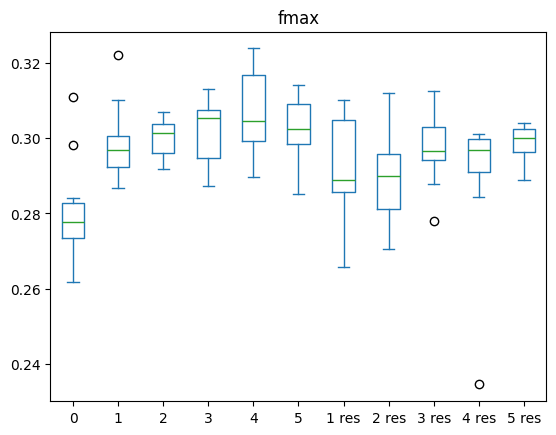

In [19]:
fmaxes = {k:[] for k in test_pred_dict_sigmoid.keys()}
for k in aucs.keys():
    for seed in range(len(test_labels_lists)):
        fmaxes[k].append(fmax_score(test_labels_lists[seed], test_pred_dict_sigmoid[k][seed])[0])
fmaxes_df = pd.DataFrame(fmaxes)
fmaxes_df.plot.box()
plt.title('fmax')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

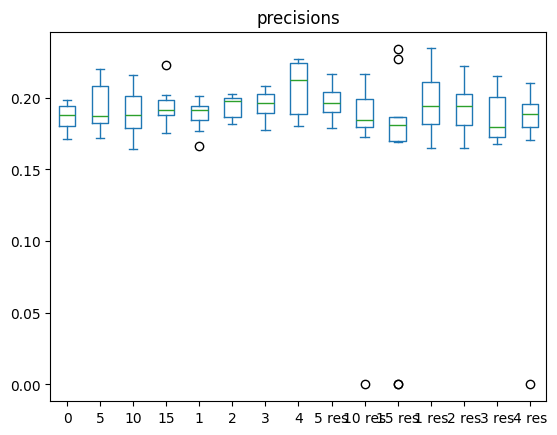

In [106]:
precisions = {k:[] for k in test_pred_dict.keys()}
for k in aucs.keys():
    for seed in range(len(test_labels_lists)):
        decisions =  [y>0.5 for y in test_pred_dict_sigmoid[k][seed]]
        precisions[k].append(precision_score(test_labels_lists[seed], decisions))
precisions_df = pd.DataFrame(precisions)
precisions_df
precisions_df.plot.box()
plt.title('precisions')
plt.show()

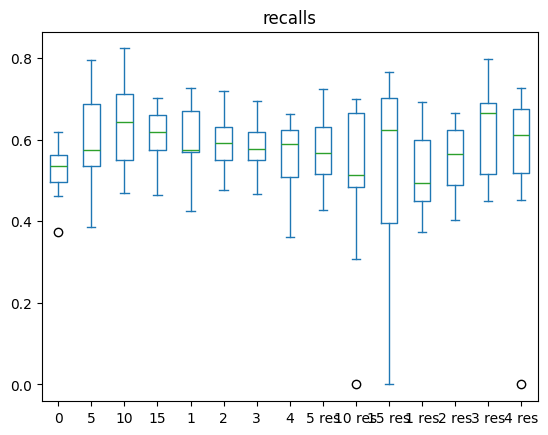

In [107]:
recalls = {k:[] for k in test_pred_dict.keys()}
for k in aucs.keys():
    for seed in range(len(test_labels_lists)):
        decisions =  [y>0.5 for y in test_pred_dict_sigmoid[k][seed]]
        recalls[k].append(recall_score(test_labels_lists[seed], decisions))
recalls_df = pd.DataFrame(recalls)
recalls_df
recalls_df.plot.box()
plt.title('recalls')
plt.show()